In [2]:
import os
import sys
import mne
import math
import time
import pickle
import argparse
import numpy as np
import pandas as pd
import mne_features
from scipy import signal
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
N_trials = 40
N_EEG_electrodes = 32

sfreq = 128
duration_trial = int( 60.0 * sfreq ) # 60 sec trial
time_window = int(2.0 * sfreq) # 2 sec time window for feature extraction
time_step = int(0.25 * sfreq) # 0.25 sec time step for feature extraction
iter_freqs = [('Delta', 0.5, 3.5),
              ('Theta', 3.5, 7),
              ('Alpha', 7, 14),
              ('Beta', 14, 28),
              ('Gamma', 28, 56)]
N_bands = len(iter_freqs)

target_names = ['Arousal', 'Valence', 'Liking', 'Dominance']

In [4]:
root_folder = 'C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP'
ratings_csv_path = os.path.join(root_folder, 'Metadata', 'metadata_csv', 'participant_ratings.csv')

npy_folder = os.path.join(os.getcwd(), 'results', 'npy')
feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')


if not os.path.exists(feats_folder):
    os.makedirs(feats_folder, exist_ok=True)

In [5]:
def get_DASM_electrode_indices():

    # DEAP_EEG_channels_xlsx_path = os.path.join(os.getcwd(), 'metadata_csv', 'DEAP_EEG_channels.xlsx')
    # EEG_channels_table = pd.read_excel(DEAP_EEG_channels_xlsx_path)
    # EEG_channels_geneva = EEG_channels_table['Channel_name_Geneva'].values
    EEG_channels_geneva = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz',
                           'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']

    EEG_asymmetric_pairs = [['Fp1', 'Fp2'],
                            ['AF3', 'AF4'],
                            ['F3', 'F4'],
                            ['F7', 'F8'],
                            ['FC5', 'FC6'],
                            ['FC1', 'FC2'],
                            ['C3', 'C4'],
                            ['T7', 'T8'],
                            ['CP5', 'CP6'],
                            ['CP1', 'CP2'],
                            ['P3', 'P4'],
                            ['P7', 'P8'],
                            ['PO3', 'PO4'],
                            ['O1', 'O2']
                            ]
    N_pairs = len(EEG_asymmetric_pairs)
    electrode_indices = np.zeros( (N_pairs, 2) )
    for pair, pair_cnt in zip(EEG_asymmetric_pairs, range(N_pairs)):
        electrode_left = pair[0]
        electrode_right = pair[1]
        index_left = EEG_channels_geneva.index(electrode_left)
        index_right = EEG_channels_geneva.index(electrode_right)
        electrode_indices[pair_cnt, 0] = index_left
        electrode_indices[pair_cnt, 1] = index_right

    electrode_indices = electrode_indices.astype(np.uint8)

    return electrode_indices

In [6]:
def get_shape_str(input):
    shape_str = ''
    N = input.ndim
    for i in range(N):
        shape_str = shape_str + '{}x'.format(input.shape[i])
    shape_str = shape_str[:-1]
    return shape_str


In [7]:
def print_values(input):
    values_str = 'Min: {:.6f} Mean: {:.6f} Max: {:.6f} Std: {:.6f} | Shape: {} | Type: {}'.format( np.min(input), np.mean(input), np.max(input), np.std(input), get_shape_str(input), type(input) )
    print(values_str)

In [8]:
def print_values_features(feature_name, features):

    band_names = ['theta', 'slow alpha', 'alpha', 'beta', 'gamma']
    band_indices = [el for el in range(len(band_names))]

    for band_name, band_index in zip(band_names, band_indices):
        print('\n{}: {} band statistics:'.format(feature_name, band_name))
        features_band = features[:,:,band_index,:].squeeze()
        print_values(features_band)

In [9]:
def get_trial_PSD(data_epoch, duration_baseline, duration_epoch, time_range, normalize=False):
    """
    input: 2d matrix x
    """

    # Split baseline (5 sec) and trial (60 sec)
    data_baseline = data_epoch[:, :duration_baseline].copy()
    data_trial = data_epoch[:, duration_baseline:].copy()

    # Compute PSD for baseline
    psd_baseline = []
    t_2 = data_baseline.shape[-1]
    t_1 = int(t_2 - time_window)
    Pxx_den, f, feats_psd = get_segment_PSD(data_baseline[:,t_1:t_2], normalize=False)
    psd_baseline.append(feats_psd)
    psd_baseline = np.array(psd_baseline)
    psd_baseline = np.transpose(psd_baseline, (1, 2, 0)) # change shape from [times x channels x bands] to [channels x bands x times]

    # Compute PSD for trial
    psd_trial = []
    for t_1 in time_range:
        t_2 = t_1 + time_window
        Pxx_den, f, feats_psd = get_segment_PSD(data_trial[:,t_1:t_2], normalize=False)
        psd_trial.append(feats_psd)
    psd_trial = np.array(psd_trial)
    psd_trial = np.transpose(psd_trial, (1, 2, 0)) # change shape from [times x channels x bands] to [channels x bands x times]

    return psd_baseline, psd_trial

In [10]:
def get_segment_PSD(x, normalize=False):
    """
    input: 2d matrix x
    """

    N_bands_PSD = 5
    N_ch = x.shape[0]
    powers = np.zeros((N_ch, N_bands_PSD))

    Pxx_den_list = []
    for ch in range(N_ch):
        f, Pxx_den = signal.welch(x[ch], fs=sfreq, nperseg=sfreq)
        Pxx_den *= 1000000.0 * 1000000.0 # adjust scaling to microvolts^2
        Pxx_den = 10 * np.log10(Pxx_den)
        Pxx_den_list.append(Pxx_den)

        power_theta = np.mean(Pxx_den[4:7+1])
        power_slow_alpha = np.mean(Pxx_den[8:10+1])
        power_alpha = np.mean(Pxx_den[8:13+1])
        power_beta = np.mean(Pxx_den[14:29+1])
        power_gamma = np.mean(Pxx_den[30:45+1])
        if normalize:
            power_sum = power_theta + power_alpha + power_beta + power_gamma
            # Normalize with sum
            power_theta = power_theta / power_sum
            power_slow_alpha = power_slow_alpha / power_sum
            power_alpha = power_alpha / power_sum
            power_beta = power_beta / power_sum
            power_gamma = power_gamma / power_sum
        powers[ch,0] = power_theta
        powers[ch,1] = power_slow_alpha
        powers[ch,2] = power_alpha
        powers[ch,3] = power_beta
        powers[ch,4] = power_gamma

    Pxx_den_list = np.array(Pxx_den_list)

    return Pxx_den_list, f, powers

In [11]:
def get_trial_DASM(psd_baseline, psd_trial):

    electrode_indices = get_DASM_electrode_indices()
    indices_left = electrode_indices[:,0].squeeze()
    indices_right = electrode_indices[:,1].squeeze()
    psd_baseline_left = psd_baseline[indices_left]
    psd_baseline_right = psd_baseline[indices_right]
    psd_trial_left = psd_trial[indices_left]
    psd_trial_right = psd_trial[indices_right]
    dasm_baseline = psd_baseline_left - psd_baseline_right
    dasm_trial = psd_trial_left - psd_trial_right

    return dasm_baseline, dasm_trial

In [12]:
def get_trial_DEASM(de_baseline, de_trial):

    # same electrode indices with DASM
    electrode_indices = get_DASM_electrode_indices()
    indices_left = electrode_indices[:,0].squeeze()
    indices_right = electrode_indices[:,1].squeeze()
    de_baseline_left = de_baseline[indices_left]
    de_baseline_right = de_baseline[indices_right]
    de_trial_left = de_trial[indices_left]
    de_trial_right = de_trial[indices_right]
    deasm_baseline = de_baseline_left - de_baseline_right
    deasm_trial = de_trial_left - de_trial_right

    return deasm_baseline, deasm_trial

In [13]:
def get_trial_DE(data_epoch, duration_baseline, duration_epoch, time_range):
    """
    input: 2d matrix x
    """

    # Assuming 5-second baseline and 60-second trial: 0-5, 5-65
    t_min_baseline = 0
    t_max_baseline = duration_baseline/sfreq
    t_min_trial = duration_baseline/sfreq
    t_max_trial = (duration_epoch-1)/sfreq

    picks = [x for x in range(N_EEG_electrodes)]
    eeg_info = mne.create_info(ch_names=N_EEG_electrodes, sfreq=sfreq)
    raw = mne.io.RawArray(data=data_epoch, info=eeg_info, verbose=False)
    # raw.plot_psd(fmin=0, fmax=55, picks=picks, area_mode='range', average=False)

    N_bands_DE = 5
    powers = np.zeros((N_EEG_electrodes, N_bands_DE))

    raw_theta = raw.copy().filter(4, 8, picks=picks, fir_design='firwin', verbose=False)
    raw_slow_alpha = raw.copy().filter(8, 10, picks=picks, fir_design='firwin', verbose=False)
    raw_alpha = raw.copy().filter(8, 12, picks=picks, fir_design='firwin', verbose=False)
    raw_beta = raw.copy().filter(12, 30, picks=picks, fir_design='firwin', verbose=False)
    raw_gamma = raw.copy().filter(30, 45, picks=picks, fir_design='firwin', verbose=False)

    raw_theta_baseline = raw_theta.copy().crop(tmin=t_min_baseline, tmax=t_max_baseline)
    raw_slow_alpha_baseline = raw_slow_alpha.copy().crop(tmin=t_min_baseline, tmax=t_max_baseline)
    raw_alpha_baseline = raw_alpha.copy().crop(tmin=t_min_baseline, tmax=t_max_baseline)
    raw_beta_baseline = raw_beta.copy().crop(tmin=t_min_baseline, tmax=t_max_baseline)
    raw_gamma_baseline = raw_gamma.copy().crop(tmin=t_min_baseline, tmax=t_max_baseline)

    data_theta_baseline = raw_theta_baseline.get_data() * 1000000.0
    data_slow_alpha_baseline = raw_slow_alpha_baseline.get_data() * 1000000.0
    data_alpha_baseline = raw_alpha_baseline.get_data() * 1000000.0
    data_beta_baseline = raw_beta_baseline.get_data() * 1000000.0
    data_gamma_baseline = raw_gamma_baseline.get_data() * 1000000.0

    raw_theta_trial = raw_theta.copy().crop(tmin=t_min_trial, tmax=t_max_trial)
    raw_slow_alpha_trial = raw_slow_alpha.copy().crop(tmin=t_min_trial, tmax=t_max_trial)
    raw_alpha_trial = raw_alpha.copy().crop(tmin=t_min_trial, tmax=t_max_trial)
    raw_beta_trial = raw_beta.copy().crop(tmin=t_min_trial, tmax=t_max_trial)
    raw_gamma_trial = raw_gamma.copy().crop(tmin=t_min_trial, tmax=t_max_trial)

    data_theta_trial = raw_theta_trial.get_data() * 1000000.0
    data_slow_alpha_trial = raw_slow_alpha_trial.get_data() * 1000000.0
    data_alpha_trial = raw_alpha_trial.get_data() * 1000000.0
    data_beta_trial = raw_beta_trial.get_data() * 1000000.0
    data_gamma_trial = raw_gamma_trial.get_data() * 1000000.0

    ###########################################################

    # Compute DE for baseline

    DE_baseline_list = []

    t_2 = data_theta_baseline.shape[-1]
    t_1 = int(t_2 - time_window)
    DE_theta_baseline = get_segment_DE(data_theta_baseline[:,t_1:t_2])
    DE_slow_alpha_baseline = get_segment_DE(data_slow_alpha_baseline[:,t_1:t_2])
    DE_alpha_baseline = get_segment_DE(data_alpha_baseline[:,t_1:t_2])
    DE_beta_baseline = get_segment_DE(data_beta_baseline[:,t_1:t_2])
    DE_gamma_baseline = get_segment_DE(data_gamma_baseline[:,t_1:t_2])
    DE_baseline = np.concatenate( (DE_theta_baseline, DE_slow_alpha_baseline, DE_alpha_baseline, DE_beta_baseline, DE_gamma_baseline), axis=1)
    DE_baseline_list.append(DE_baseline)
    DE_baseline_list = np.array(DE_baseline_list)
    DE_baseline_list = np.transpose(DE_baseline_list, (1, 2, 0)) # change shape from [times x channels x bands] to [channels x bands x times]

    ###########################################################

    # Compute DE for trial

    DE_trial_list = []

    for t_1 in time_range:
        t_2 = t_1 + time_window
        DE_theta_trial = get_segment_DE(data_theta_trial[:,t_1:t_2])
        DE_slow_alpha_trial = get_segment_DE(data_slow_alpha_trial[:,t_1:t_2])
        DE_alpha_trial = get_segment_DE(data_alpha_trial[:,t_1:t_2])
        DE_beta_trial = get_segment_DE(data_beta_trial[:,t_1:t_2])
        DE_gamma_trial = get_segment_DE(data_gamma_trial[:,t_1:t_2])
        DE_trial = np.concatenate( (DE_theta_trial, DE_slow_alpha_trial, DE_alpha_trial, DE_beta_trial, DE_gamma_trial), axis=1)
        DE_trial_list.append(DE_trial)
    DE_trial_list = np.array(DE_trial_list)
    DE_trial_list = np.transpose(DE_trial_list, (1, 2, 0)) # change shape from [times x channels x bands] to [channels x bands x times]

    ###########################################################

    return DE_baseline_list, DE_trial_list

In [14]:
def get_segment_DE(x):

    stds = np.std(x, axis=1)
    DE = 0.5 * np.log10( 2*math.pi*math.exp(1) * ( stds**2) )
    DE = np.expand_dims(DE, axis=1)

    return DE

In [15]:
def load_data(subject_id):
    npy_file_path = os.path.join(npy_folder, 's{:02d}.npy'.format(subject_id))
    print('Loading preprocessed EEG from .npy file {}\n'.format(npy_file_path))
    data = np.load(npy_file_path)
    print('data loaded')
    return data

In [16]:
def extract_features(data, subject_id):

    feats_path = os.path.join(feats_folder, 's{:02}.npy'.format(subject_id))

    if os.path.exists(feats_path):
        print('\nFeatures are already saved.\nSkipping feature extraction for Subject {:02}'.format(subject_id))
        return 0

    extract_time_1 = time.time()
    print('\nExtracting features for Subject {:02}'.format(subject_id))


    # Load ratings
    ratings = pd.read_csv(ratings_csv_path)
    is_subject =  (ratings['Participant_id'] == subject_id)
    ratings_subj = ratings[is_subject]

    duration_epoch = data.shape[-1]
    duration_baseline = duration_epoch - duration_trial
    time_range = range(0, duration_trial - time_window, time_step)
    time_range = np.array([x for x in time_range])

    features = {}
    features['duration_epoch'] = duration_epoch
    features['duration_baseline'] = duration_baseline
    features['duration_trial'] = duration_trial
    features['time_step'] = time_step
    features['time_window'] = time_window
    features['time_range'] = time_range
    features['psd_baseline'] = []
    features['psd_trial'] = []
    features['dasm_baseline'] = []
    features['dasm_trial'] = []
    features['de_baseline'] = []
    features['de_trial'] = []
    features['deasm_baseline'] = []
    features['deasm_trial'] = []
    features['ratings'] = []

    for i in range(N_trials):
        print('Extracting features for trial {:02}'.format(i+1))

        ######################
        # Get ratings

        exp_id = i+1
        is_exp = (ratings['Experiment_id'] == exp_id)
        trial_id = ratings_subj[is_exp]['Trial'].values[0]
        # arousal = ratings_subj[is_exp]['Arousal'].values[0]
        # valence = ratings_subj[is_exp]['Valence'].values[0]
        # liking = ratings_subj[is_exp]['Liking'].values[0]
        # dominance = ratings_subj[is_exp]['Dominance'].values[0]
        ratings_trial = [ratings_subj[is_exp][target_name].values[0] for target_name in target_names]
        ratings_trial = np.array(ratings_trial)
        features['ratings'].append(ratings_trial)
        #####################################################

        data_epoch = data[i]

        #####################################################
        # Compute PSD features

        psd_baseline, psd_trial = get_trial_PSD(data_epoch, duration_baseline, duration_epoch, time_range, normalize=False)
        features['psd_baseline'].append(psd_baseline)
        features['psd_trial'].append(psd_trial)

        #####################################################
        # Compute DASM features

        dasm_baseline, dasm_trial = get_trial_DASM(psd_baseline, psd_trial)
        features['dasm_baseline'].append(dasm_baseline)
        features['dasm_trial'].append(dasm_trial)

        #####################################################
        # Compute DE features

        de_baseline, de_trial = get_trial_DE(data_epoch, duration_baseline, duration_epoch, time_range)
        features['de_baseline'].append(de_baseline)
        features['de_trial'].append(de_trial)

        #####################################################
        # Compute DEASM features

        deasm_baseline, deasm_trial = get_trial_DEASM(de_baseline, de_trial)
        features['deasm_baseline'].append(deasm_baseline)
        features['deasm_trial'].append(deasm_trial)

        #####################################################
    features['psd_baseline'] = np.array(features['psd_baseline'])
    features['psd_trial'] = np.array(features['psd_trial'])
    features['dasm_baseline'] = np.array(features['dasm_baseline'])
    features['dasm_trial'] = np.array(features['dasm_trial'])
    features['de_baseline'] = np.array(features['de_baseline'])
    features['de_trial'] = np.array(features['de_trial'])
    features['deasm_baseline'] = np.array(features['deasm_baseline'])
    features['deasm_trial'] = np.array(features['deasm_trial'])
    features['ratings'] = np.array(features['ratings'])

    #########################################################

    print('\nExtracted PSD features shape: {}'.format(features['psd_trial'].shape))
    print('Extracted DASM features shape: {}'.format(features['dasm_trial'].shape))
    print('Extracted DE features shape: {}'.format(features['de_trial'].shape))
    print('Extracted DEASM features shape: {}'.format(features['deasm_trial'].shape))

    print('\nSaving the extracted features in a .npy file')
    np.save(feats_path, features)

    # print_values_features(feature_name='DEASM', features=features['deasm_trial'])

    extract_time_2 = time.time()
    print('\nFinished in {:.2f} seconds.'.format(extract_time_2 - extract_time_1))



In [21]:
data = load_data(1)

Loading preprocessed EEG from .npy file C:\Users\thiag\OneDrive - Georgia Institute of Technology\DEAP\Scripts\results\npy\s01.npy

data loaded


In [22]:
data.shape

(40, 32, 8320)

In [96]:
def calc_bands(data):
    freq_bands = {}
    for band, fmin, fmax in iter_freqs:
        filtered = mne.filter.filter_data(data, sfreq, fmin, fmax, verbose=False)
        filt_dic = dict(enumerate(filtered))
        freq_bands[band] = filt_dic
    return freq_bands

In [90]:
def extract_phase(array):
    analytic_signal = signal.hilbert(array)
    instantaneous_phase = (np.angle(analytic_signal))
    phase = np.where(instantaneous_phase > 0, 1, -1)
    return instantaneous_phase/np.pi, phase

In [109]:
def PLV(epoch_1, epoch_2):
    instant_phase_1, phase_1 = extract_phase(epoch_1)
    instant_phase_2, phase_2 = extract_phase(epoch_2)
    inst_phase_sum = instant_phase_1 - instant_phase_2
    PLV = (np.exp(1j*inst_phase_sum))
    return np.abs(np.mean(PLV))

In [97]:
freq_bands = calc_bands(data)

array_0 = freq_bands['Theta'][0][0]
array_1 = freq_bands['Theta'][0][1]


In [100]:
PLV = PLV(array_0, array_1)

In [101]:
print(PLV)

0.9104874276049519


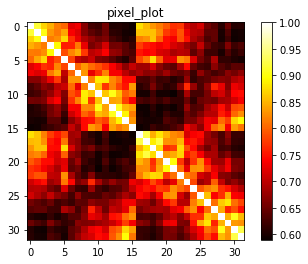

In [127]:
epoch = 0
band = 'Alpha'
connectivity = np.zeros((N_EEG_electrodes,N_EEG_electrodes))
for (idx_x, ch_x) in enumerate(freq_bands[band][epoch]):
    for (idx_y, ch_y) in enumerate(freq_bands[band][epoch]):
        connectivity[idx_x][idx_y] = PLV(ch_x, ch_y)
          
pixel_plot = plt.figure()
pixel_plot.add_axes()
plt.title("pixel_plot")
pixel_plot = plt.imshow(
  connectivity, cmap='hot', interpolation='nearest')
plt.colorbar(pixel_plot)
plt.show(pixel_plot)

In [138]:
avg_connectivity = np.zeros(N_trials)
band = 'Alpha'
connectivity = np.zeros((N_EEG_electrodes,N_EEG_electrodes))

for epoch in range(N_trials):
    for idx_x in range(freq_bands[band][epoch].shape[0]):
        for idx_y in range(freq_bands[band][epoch].shape[0]):
            ch_x = freq_bands[band][epoch][idx_x]
            ch_y = freq_bands[band][epoch][idx_y]
            connectivity[idx_x][idx_y] = PLV(ch_x, ch_y)
            
    avg_connectivity[epoch] = np.mean(connectivity)

In [140]:
avg_connectivity = np.zeros(N_trials)
band = 'Beta'
connectivity = np.zeros((N_EEG_electrodes,N_EEG_electrodes))

for epoch in range(N_trials):
    for idx_x in range(freq_bands[band][epoch].shape[0]):
        for idx_y in range(freq_bands[band][epoch].shape[0]):
            ch_x = freq_bands[band][epoch][idx_x]
            ch_y = freq_bands[band][epoch][idx_y]
            connectivity[idx_x][idx_y] = PLV(ch_x, ch_y)
            
    avg_connectivity[epoch] = np.mean(connectivity)

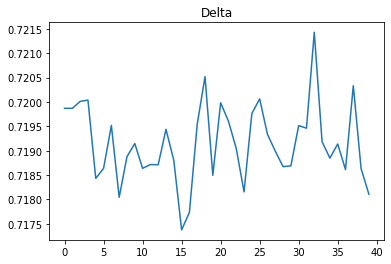

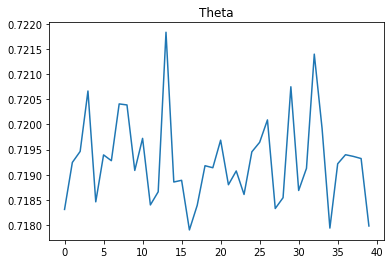

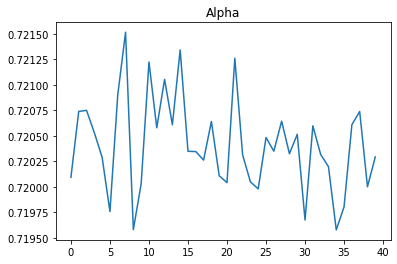

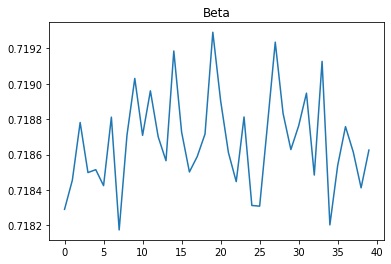

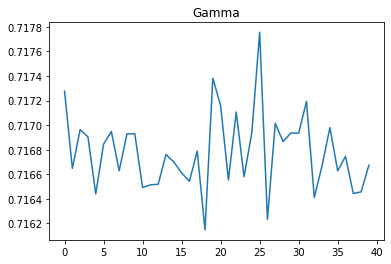

In [144]:
avg_connectivity = np.zeros(N_trials)
connectivity = np.zeros((N_EEG_electrodes,N_EEG_electrodes))

for freq in iter_freqs:
    band = freq[0]
    for epoch in range(N_trials):
        for idx_x in range(freq_bands[band][epoch].shape[0]):
            for idx_y in range(freq_bands[band][epoch].shape[0]):
                ch_x = freq_bands[band][epoch][idx_x]
                ch_y = freq_bands[band][epoch][idx_y]
                connectivity[idx_x][idx_y] = PLV(ch_x, ch_y)

        avg_connectivity[epoch] = np.mean(connectivity)
    plt.plot(avg_connectivity)
    plt.title(band)
    plt.show()